In [1]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

from flavors.activate_function import ActivateFunctionController, ActivateFunctions

In [ ]:
Lx = 5.0
Ly = 1.0
T = 1.0
nu = 0.01

U = 1



class NavierStokesModel(nn.Module):
    def __init__(self):
        super(NavierStokesModel, self).__init__()

        self.activation_func = ActivateFunctionController(
            activate_func=ActivateFunctions.AdaptiveBlendingUnit, args=dict()
        ).get()

        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.activation_func(self.fc3(x))
        return self.fc4(x)

global_epoch = 0
writer = SummaryWriter()
model = NavierStokesModel()


def compute_pde(xyt):
    global global_epoch
    xyt.requires_grad_(True)
    up = model(xyt)
    u, v, p = up[:, 0], up[:, 1], up[:, 2]

    u_x = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 1]
    u_t = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 2]
    v_x = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 0]
    v_y = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 1]
    v_t = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 2]
    p_x = torch.autograd.grad(p.sum(), xyt, create_graph=True)[0][:, 0]
    p_y = torch.autograd.grad(p.sum(), xyt, create_graph=True)[0][:, 1]

    u_xx = torch.autograd.grad(u_x.sum(), xyt, create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y.sum(), xyt, create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x.sum(), xyt, create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y.sum(), xyt, create_graph=True)[0][:, 1]

    continuity = u_x + v_y

    momentum_x = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    momentum_y = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)


    writer.add_scalar("pde/continuity", torch.abs(torch.mean(continuity)), global_epoch)
    writer.add_scalar("pde/momentum_x", torch.abs(torch.mean(momentum_x)), global_epoch)
    writer.add_scalar("pde/momentum_y", torch.abs(torch.mean(momentum_y)), global_epoch)

    return continuity, momentum_x, momentum_y


def boundary_conditions():
    num_points = 1000
    t = T * np.random.random(num_points)
    bottom_bc = torch.tensor(
        np.stack(
            [np.random.uniform(0, Lx, num_points), np.zeros(num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    left_bc = torch.tensor(
        np.stack(
            [np.zeros(num_points), np.random.uniform(0, Ly, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    top_bc = torch.tensor(
        np.stack(
            [np.random.uniform(0, Lx, num_points), np.full(num_points, Ly), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    right_bc = torch.tensor(
        np.stack(
            [np.full(num_points, Lx), np.random.uniform(0, Ly, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)

    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    left_loss = torch.mean(p**2)
    u, v, p = top_predict[:, 0], top_predict[:, 1], top_predict[:, 2]
    top_loss = torch.mean((u - U)**2 + v**2)
    u, v, p = bottom_predict[:, 0], bottom_predict[:, 1], bottom_predict[:, 2]
    bottom_loss = torch.mean(u**2 + v**2)
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    right_loss = torch.mean(p**2)

    writer.add_scalar("bc/bottom", torch.mean(bottom_loss), global_epoch)
    writer.add_scalar("bc/left", torch.mean(left_loss), global_epoch)
    writer.add_scalar("bc/right", torch.mean(right_loss), global_epoch)
    writer.add_scalar("bc/top", torch.mean(top_loss), global_epoch)

    return right_loss + bottom_loss + top_loss +left_loss


def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    t = np.random.uniform(0, T, num_points)
    xyt = np.stack([x, y, t], axis=-1)
    return torch.tensor(xyt, requires_grad=True).float()


def loss_function(xyt):
    continuity, momentum_x, momentum_y = compute_pde(xyt)
    pde_loss = (
        torch.mean(continuity**2)
        + torch.mean(momentum_x**2)
        + torch.mean(momentum_y**2)
    )
    bc_loss = boundary_conditions()
    total_loss = pde_loss + bc_loss
    return total_loss


In [3]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000
num_points = 1000
for epoch in range(num_epochs):
    global_epoch += 1
    xyt = generate_data(num_points)
    optimizer.zero_grad()
    loss = loss_function(xyt)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training completed.")


Epoch 0, Loss: 1.9686079025268555
Epoch 100, Loss: 0.004577029962092638
Epoch 200, Loss: 0.001116608502343297
Epoch 300, Loss: 0.0005725764203816652
Epoch 400, Loss: 0.00031617452623322606
Epoch 500, Loss: 0.00017347773246001452
Epoch 600, Loss: 0.00010287594341207296
Epoch 700, Loss: 7.209126488305628e-05
Epoch 800, Loss: 5.195903577259742e-05
Epoch 900, Loss: 4.3159699998795986e-05
Training completed.


In [4]:
def plot_flow_data():
    nx, ny, nt = 50, 50, 4
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    t = np.linspace(0, T, nt)
    X, Y, t_grid = np.meshgrid(x, y, t)
    XYT = np.stack([X.flatten(), Y.flatten(), t_grid.flatten()], axis=-1)
    XYT_tensor = torch.tensor(XYT, requires_grad=False).float()

    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.flatten(), Y.flatten()], axis=-1)


    with torch.no_grad():
        predictions = model(XYT_tensor).numpy()

    U_calc = predictions[:, 0].reshape((ny, nx, nt))
    V_calc = predictions[:, 1].reshape((ny, nx, nt))
    P_calc = predictions[:, 2].reshape((ny, nx, nt))


    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    axs.quiver(
        X, Y, U_calc[:, :, -1], V_calc[:, :, -1], scale=10, scale_units="xy"
    )
    axs.set_title(f"Calculated solution")
    axs.set_xlabel("x")
    axs.set_ylabel("y")

    plt.tight_layout()
    plt.show()

    U_exact = np.tile(U / Ly * y, (nx)).reshape(nx, ny).T
    V_exact = 0 * y[None, :] * x[:, None]


    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    axs.quiver(
        X, Y, U_exact, V_exact, scale=10, scale_units="xy"
    )
    axs.set_title(f"Exact solution")
    axs.set_xlabel("x")
    axs.set_ylabel("y")

    plt.tight_layout()
    plt.show()

    U_error = np.abs(U_exact - U_calc[:, :, 0])
    V_error = np.abs(V_exact - V_calc[:, :, 0])

    error = np.sqrt(U_error**2 + V_error**2)

    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    c3 = axs.contourf(X, Y, error, levels=50, cmap="viridis")
    axs.set_title("Error")
    fig.colorbar(c3)
    axs.set_xlabel("x")
    axs.set_ylabel("y")

    plt.tight_layout()
    plt.show()


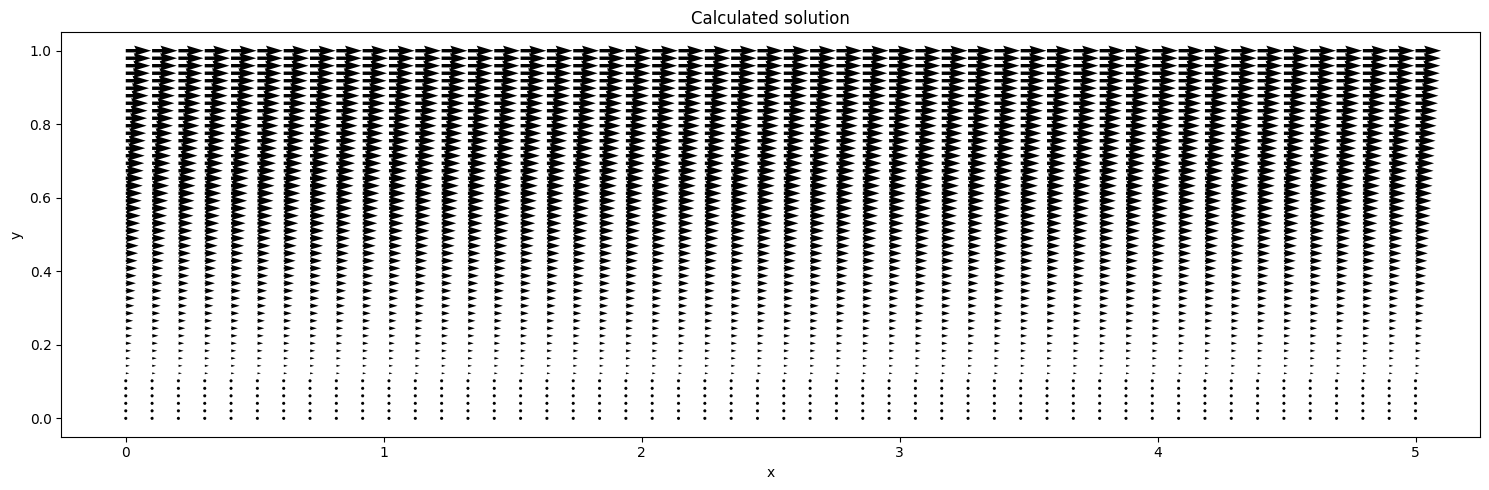

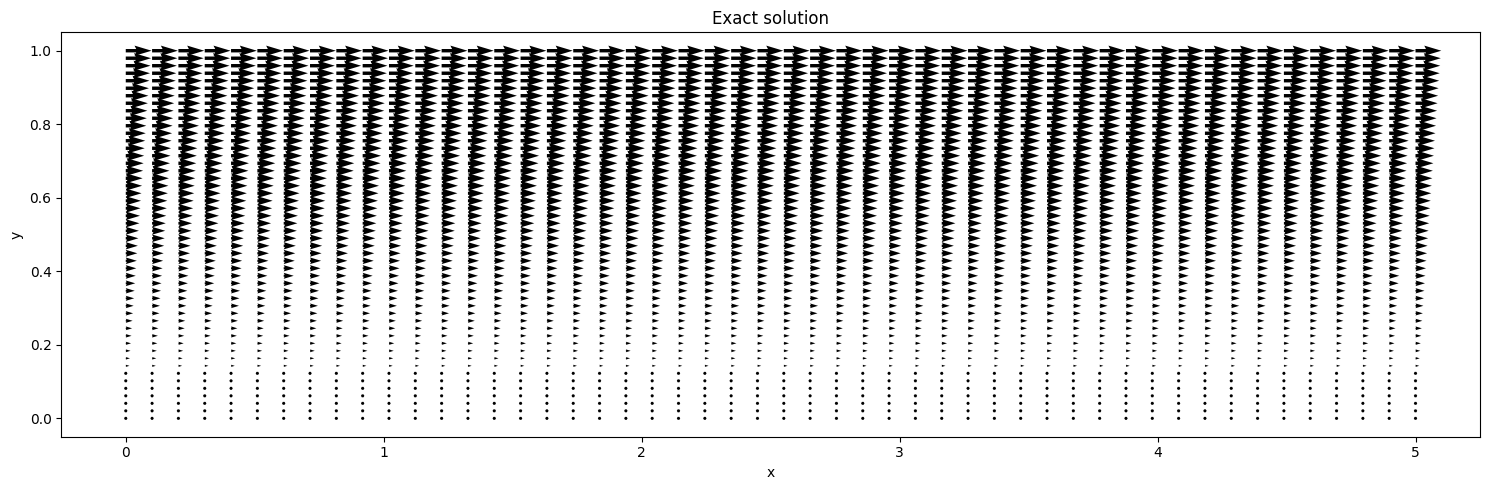

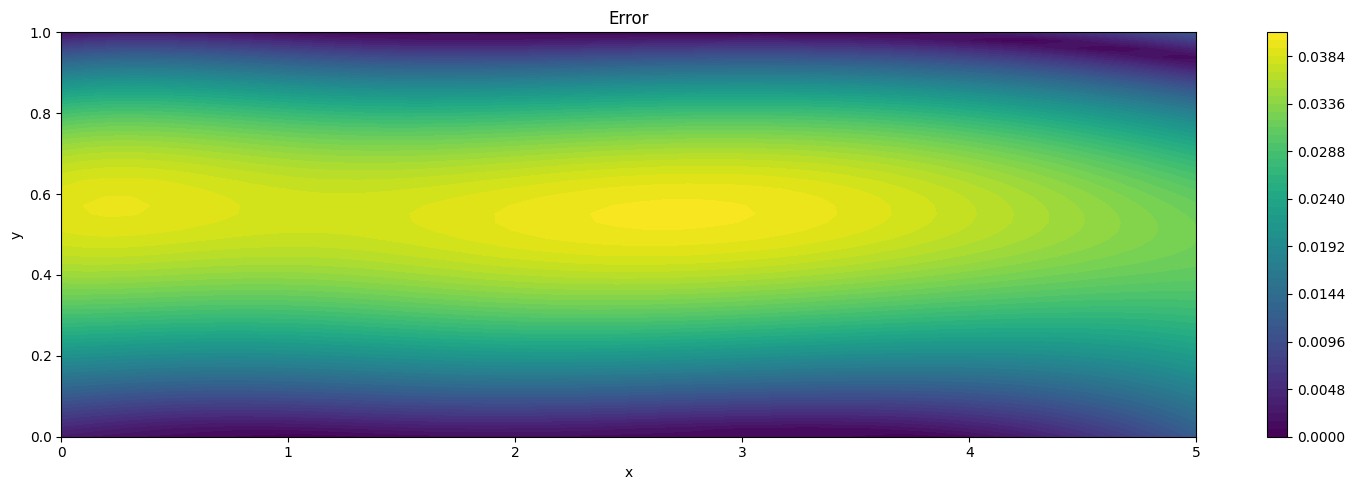

In [5]:
plot_flow_data()

In [6]:

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)


num_epochs = 1000
num_points = 1000
for epoch in range(num_epochs):
    xyt = generate_data(num_points)
    optimizer.zero_grad()
    loss = loss_function(xyt)
    # loss.backward()
    # optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
print("Training completed.")

Epoch 0, Loss: 3.6888886825181544e-05
Epoch 100, Loss: 3.772762283915654e-05
Epoch 200, Loss: 3.582730278139934e-05
Epoch 300, Loss: 3.738901432370767e-05
Epoch 400, Loss: 3.6631186958402395e-05
Epoch 500, Loss: 3.6198274756316096e-05
Epoch 600, Loss: 3.5978730011265725e-05
Epoch 700, Loss: 3.5869463317794725e-05
Epoch 800, Loss: 3.508559530018829e-05
Epoch 900, Loss: 3.7444333429448307e-05
Training completed.


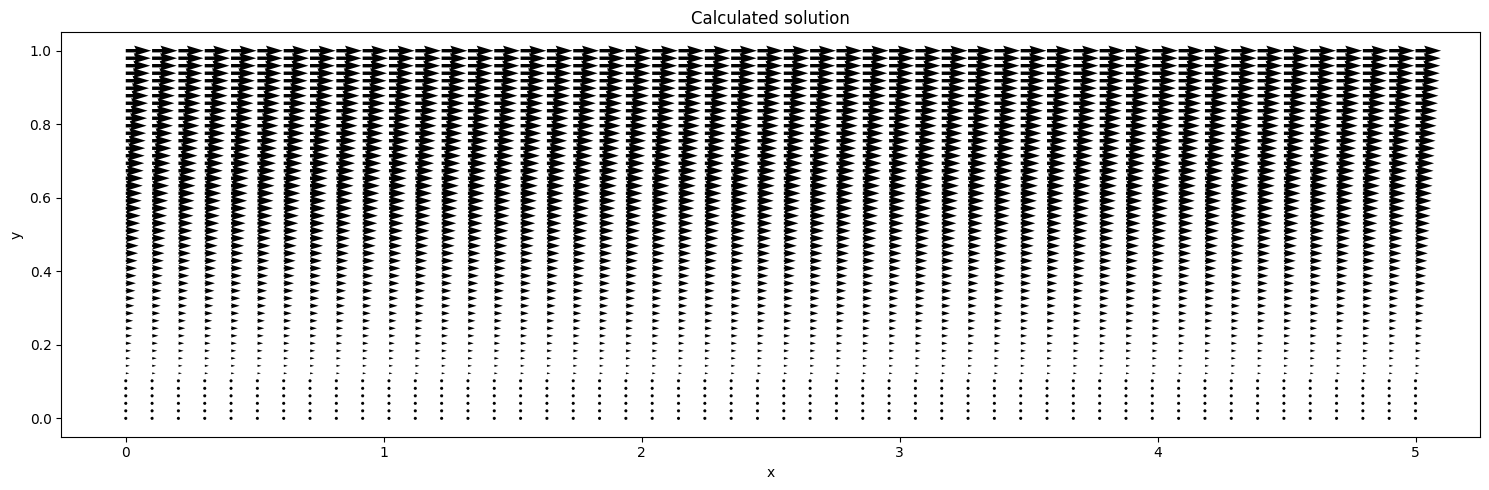

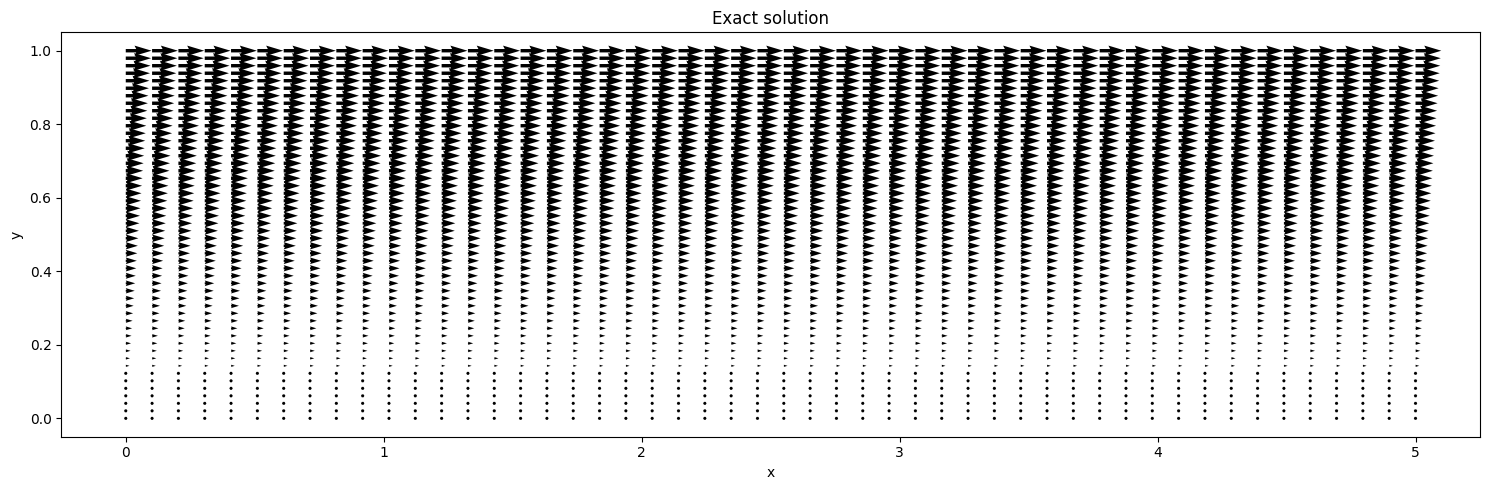

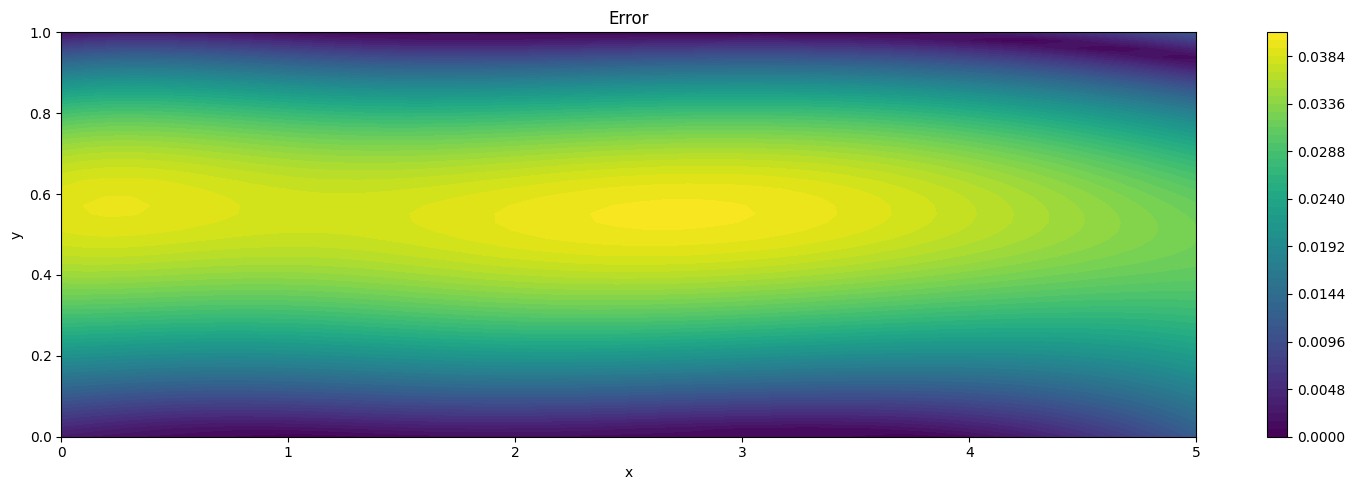

In [7]:
plot_flow_data()